In [1]:
import os
import zipfile
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
import pyodbc
import rioxarray
import numpy as np
import xarray as xr
from functools import partial
from shapely.geometry import box

# Define base paths
data_dir = "../data"
Images_dir = "../images/load"
climate_dir = os.path.join(data_dir, "climate")
fire_dir = os.path.join(data_dir, "fire")
landcover_dir = os.path.join(data_dir, "land cover")
soil_dir = os.path.join(data_dir, "soil")
elevation_dir = os.path.join(data_dir, "elevation")
elevation_n_dir = os.path.join(data_dir, "elevation_new")
loaded_data_dir = os.path.join(data_dir, "loaded")

# Initial load

## fire

In [3]:
# Algeria fire points
algeria_fire = pd.read_csv(os.path.join(fire_dir, "viirs-jpss1_2024_Algeria.csv"))
print("Algeria fire data shape:", algeria_fire.shape)
print(algeria_fire.head())

# Tunisia fire points
tunisia_fire = pd.read_csv(os.path.join(fire_dir, "viirs-jpss1_2024_Tunisia.csv"))
print("Tunisia fire data shape:", tunisia_fire.shape)
print(tunisia_fire.head())


Algeria fire data shape: (87446, 15)
   latitude  longitude  bright_ti4  scan  track    acq_date  acq_time  \
0  27.72818    9.87200      295.51  0.76   0.77  2024-01-01         3   
1  28.63288    9.77909      301.80  0.79   0.78  2024-01-01         3   
2  28.64012    9.77953      298.65  0.79   0.78  2024-01-01         3   
3  36.74886    6.25409      338.04  0.46   0.39  2024-01-01       141   
4  35.87978    4.44782      309.49  0.41   0.37  2024-01-01       141   

  satellite instrument confidence  version  bright_ti5   frp daynight  type  
0       N20      VIIRS          n        2      277.66  1.24        N     2  
1       N20      VIIRS          n        2      277.05  1.57        N     2  
2       N20      VIIRS          n        2      277.04  1.34        N     2  
3       N20      VIIRS          n        2      257.28  5.21        N     2  
4       N20      VIIRS          n        2      272.08  1.58        N     2  
Tunisia fire data shape: (2804, 15)
   latitude  longitu

## climate

In [4]:
climate_dirs = {
    "prec": os.path.join(climate_dir, "prec"),
    "tmax": os.path.join(climate_dir, "tmax"),
    "tmin": os.path.join(climate_dir, "tmin")
}

In [ ]:
# 📌code commented out because it deletes files from disk

# use loop to filter 2024 rasters for prec, tmin, tmax and delete others from memory

# for var, folder in climate_dirs.items():
#     for f in os.listdir(folder):
#         if f.endswith(".tif") and "2024" not in f:
#             os.remove(os.path.join(folder, f))
#             print(f"Deleted {var} raster: {f}")

# print("✅ All non-2024 rasters deleted from disk")

In [5]:
climate_data = {}

# --- Load rasters ---
for var, extract_path in climate_dirs.items():
    tif_files = [f for f in os.listdir(extract_path) if f.endswith(".tif")]
    if not tif_files:
        print(f"No TIFF found for {var}")
        continue
    
    climate_data[var] = []
    for tif in tif_files:
        raster_path = os.path.join(extract_path, tif)
        src = rasterio.open(raster_path)
        climate_data[var].append(src)
    print(f"{var} rasters loaded: {len(climate_data[var])} files")

prec rasters loaded: 12 files
tmax rasters loaded: 12 files
tmin rasters loaded: 12 files


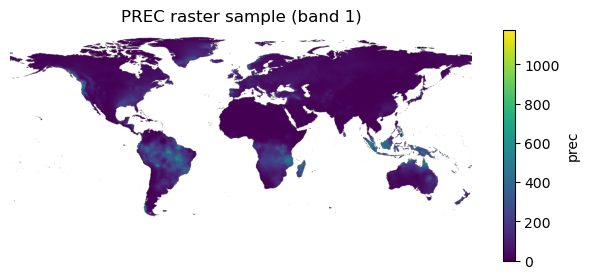

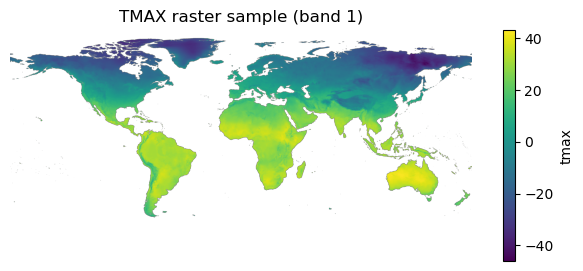

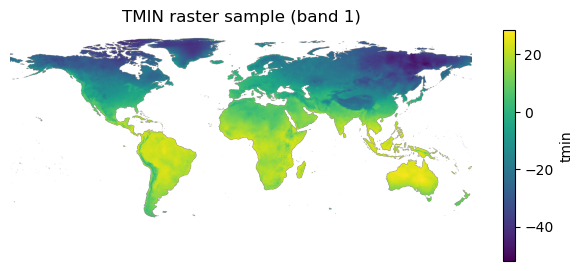

In [4]:
# --- Display one sample raster for each variable ---
for var, rasters in climate_data.items():
    src = rasters[0]
    band_number = 1
    data = src.read(band_number)
    plt.figure(figsize=(8, 3))
    plt.imshow(data, cmap='viridis')
    plt.colorbar(label=var)
    plt.title(f"{var.upper()} raster sample (band {band_number})")
    plt.axis("off")
    plt.savefig(os.path.join(Images_dir, f"{var}_raster_sample_original.png"))
    plt.show()

## soil

In [6]:
# get paths for soil data files

soil_raster_dir = os.path.join(soil_dir, "HWSD_raster")
soil_raster_bil_path = os.path.join(soil_raster_dir, "HWSD2.bil")
soil_raster_hdr_path = os.path.join(soil_raster_dir, "HWSD2.hdr")
soil_db_path = os.path.join(soil_dir, "HWSD2_DB", "HWSD2.mdb")

In [6]:
# print HWSD2.hdr content
with open(soil_raster_hdr_path, 'r') as f:
    hdr_content = f.read()
print(hdr_content)

BYTEORDER      I
LAYOUT         BIL
NROWS          21600
NCOLS          43200
NBANDS         1
NBITS          16
BANDROWBYTES   86400
TOTALROWBYTES  86400
PIXELTYPE      UNSIGNEDINT
ULXMAP         -179.995833333333
ULYMAP         89.9958333333333
XDIM           0.00833333333333333
YDIM           0.00833333333333333
NODATA         65535



In [7]:
# print .bil file info
with rasterio.open(soil_raster_bil_path) as src:
    print("HWSD2.bil metadata:", src.meta)
    print("HWSD2.bil CRS:", src.crs)
    print("HWSD2.bil bounds:", src.bounds)
    print("HWSD2.bil shape:", src.shape)
    band1 = src.read(1)
    print("HWSD2.bil data (band 1):\n", band1)  # read first band data
    print("HWSD2.bil data (band 1) non-nan values:\n", band1[~np.isnan(band1)])

HWSD2.bil metadata: {'driver': 'EHdr', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 43200, 'height': 21600, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]'), 'transform': Affine(0.00833333333333333, 0.0, -179.99999999999966,
       0.0, -0.00833333333333333, 89.99999999999996)}
HWSD2.bil CRS: OGC:CRS84
HWSD2.bil bounds: BoundingBox(left=-179.99999999999966, bottom=-89.99999999999996, right=180.00000000000017, top=89.99999999999996)
HWSD2.bil shape: (21600, 43200)
HWSD2.bil data (band 1):
 [[65535 65535 65535 ... 65535 65535 65535]
 [65535 65535 65535 ... 65535 65535 65535]
 [65535 65535 65535 ... 65535 65535 65535]
 ...
 [65535 65535 65535 ... 65535 65535 65535]
 [65535 65535 65535 ... 65535 65535 65535]
 [65535 65535 65535 ... 65535 65535 65535]]
HWSD2.bil data (band 1) no

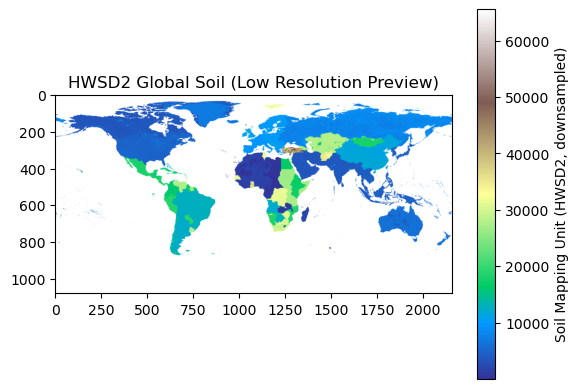

In [8]:
with rasterio.open(soil_raster_bil_path) as src:
    # Downsample by factor 20
    data = src.read(
        1,
        out_shape=(
            int(src.height / 20),
            int(src.width / 20)
        ),
        resampling=Resampling.average
    )

plt.imshow(data, cmap="terrain")
plt.colorbar(label="Soil Mapping Unit (HWSD2, downsampled)")
plt.title("HWSD2 Global Soil (Low Resolution Preview)")
plt.savefig(os.path.join(Images_dir, "soil_hwsd2_downsampled_preview_original.png"))
plt.show()


In [7]:
soil_mdb_path = os.path.join(soil_dir, "HWSD2_DB", "HWSD2.mdb")

conn_str = r"Driver={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=" + soil_mdb_path + ";"
conn = pyodbc.connect(conn_str)
cursor = conn.cursor()
sql = "SELECT * FROM HWSD2_LAYERS WHERE LAYER='D1'"
cursor.execute(sql)
cols = [col[0] for col in cursor.description]
rows = cursor.fetchall()
soil_mdb_df = pd.DataFrame.from_records(rows, columns=cols)
cursor.close()
conn.close()

print("Soil data DB shape:", soil_mdb_df.shape)
print("columns:", soil_mdb_df.columns.tolist())
print(soil_mdb_df.head())

Soil data DB shape: (58405, 48)
columns: ['ID', 'HWSD2_SMU_ID', 'NSC_MU_SOURCE1', 'NSC_MU_SOURCE2', 'WISE30s_SMU_ID', 'HWSD1_SMU_ID', 'COVERAGE', 'SEQUENCE', 'SHARE', 'NSC', 'WRB_PHASES', 'WRB4', 'WRB2', 'FAO90', 'ROOT_DEPTH', 'PHASE1', 'PHASE2', 'ROOTS', 'IL', 'SWR', 'DRAINAGE', 'AWC', 'ADD_PROP', 'LAYER', 'TOPDEP', 'BOTDEP', 'COARSE', 'SAND', 'SILT', 'CLAY', 'TEXTURE_USDA', 'TEXTURE_SOTER', 'BULK', 'REF_BULK', 'ORG_CARBON', 'PH_WATER', 'TOTAL_N', 'CN_RATIO', 'CEC_SOIL', 'CEC_CLAY', 'CEC_EFF', 'TEB', 'BSAT', 'ALUM_SAT', 'ESP', 'TCARBON_EQ', 'GYPSUM', 'ELEC_COND']
    ID  HWSD2_SMU_ID NSC_MU_SOURCE1 NSC_MU_SOURCE2 WISE30s_SMU_ID  \
0  667         12704           None           None     WD10012704   
1  668         12705           None           None     WD10012705   
2  669         12707           None           None     WD10012707   
3  670         12708           None           None     WD10012708   
4  695         11825           None           None     WD30011825   

   HWSD1_SMU_I

## elevation

In [8]:
elevation_path = os.path.join(elevation_n_dir, "be15_grd", "be15_grd")

with rasterio.open(elevation_path) as src:
    elevation = src.read(1)
    profile = src.profile

print("CRS:", src.crs)
print("Shape:", elevation.shape)
print("Bounds:", src.bounds)


CRS: EPSG:4326
Shape: (33600, 86400)
Bounds: BoundingBox(left=-180.00013888888893, bottom=-56.00013888888891, right=179.99986111111085, top=83.999861111111)


Downsampled shape: (6720, 17280)


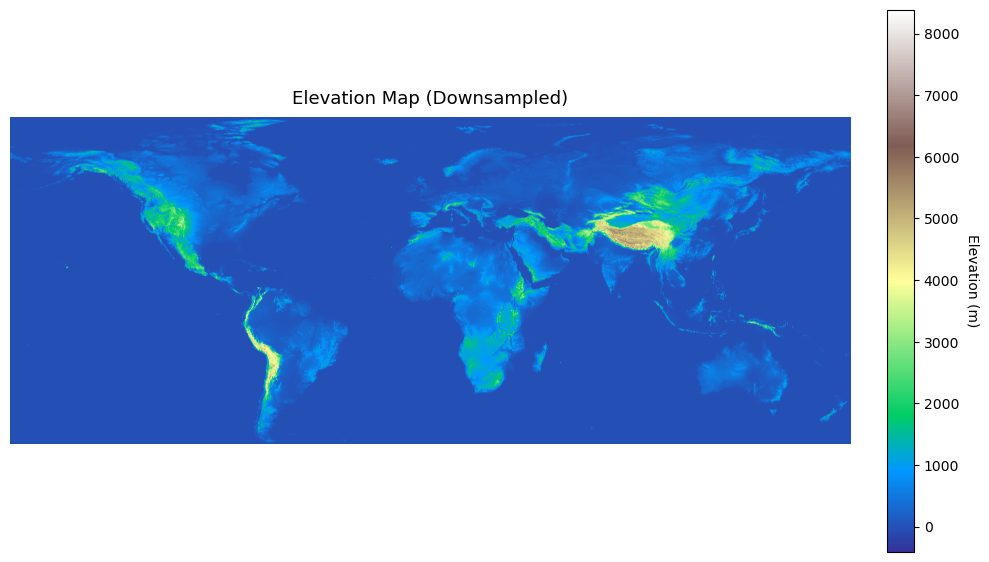

Saved preview at: ../images\elevation_n_downsampled_preview.png


In [12]:
with rasterio.open(elevation_path) as src:
    # Downsample to reduce memory usage (factor = 5 → 1/25 of original pixels)
    scale = 5
    elevation = src.read(
        1,
        out_shape=(
            int(src.height / scale),
            int(src.width / scale)
        ),
        resampling=Resampling.average
    ).astype("float32")

    print("Downsampled shape:", elevation.shape)

# viz
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(elevation, cmap="terrain")

# proportional colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.03, pad=0.04, shrink=0.8)
cbar.set_label("Elevation (m)", rotation=270, labelpad=15)

ax.set_title("Elevation Map (Downsampled)", fontsize=13, pad=10)
ax.axis("off")

plt.tight_layout()
save_path = os.path.join(Images_dir, "elevation_n_downsampled_preview.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved preview at: {save_path}")


## land cover

In [ ]:
# 📌 code commented out because we unzipped files

# # === Extract land cover ZIP and delete after ===
# zip_name = "geonetwork_landcover_DZA_gc_adg.zip"
# zip_path = os.path.join(landcover_dir, zip_name)

# if os.path.exists(zip_path):
#     with zipfile.ZipFile(zip_path, 'r') as z:
#         z.extractall(landcover_dir)
#     print(f"✅ Extracted: {zip_name}")

#     os.remove(zip_path)
#     print("🗑️ Deleted ZIP file to save space.")
# else:
#     print("⚠️ ZIP file not found:", zip_path)

# # List extracted files
# files = [f for f in os.listdir(landcover_dir) if not f.endswith(".zip")]
# print("\n📁 Extracted files:")
# for f in files:
#     print("  ├──", f)


In [15]:
landcover_dir_dz = "../data/land cover/dz"
shp_path_dz = os.path.join(landcover_dir_dz, "dza_gc_adg.shp")

gdf_dz = gpd.read_file(shp_path_dz)
print("🧩 Columns:", list(gdf_dz.columns))
print(gdf_dz.head())


🧩 Columns: ['ID', 'GRIDCODE', 'AREA', 'LCCCODE', 'geometry']
   ID  GRIDCODE          AREA       LCCCODE  \
0   4       210  6.228187e+06  7001 // 8001   
1   2       210  6.242408e+06  7001 // 8001   
2   1       210  1.482995e+06  7001 // 8001   
3   8        50  4.590841e+08  21497-121340   
4  13       210  6.371533e+06  7001 // 8001   

                                            geometry  
0  POLYGON ((6.41528 37.08696, 6.43103 37.0855, 6...  
1  POLYGON ((7.18084 37.07917, 7.17998 37.08091, ...  
2  POLYGON ((7.37137 37.08194, 7.3709 37.08717, 7...  
3  POLYGON ((6.12361 36.68472, 6.12361 36.69306, ...  
4  POLYGON ((6.26181 37.02361, 6.26193 37.02514, ...  


In [ ]:
# plot dza_gc_adg.shp
gdf_dz.plot(column="GRIDCODE", cmap="tab20", legend=True, figsize=(10, 5))
plt.title("Algeria Land Cover Types")
plt.savefig(os.path.join(Images_dir, "dz_land_cover_types.png"))
plt.show()

In [16]:
landcover_dir_tn = "../data/land cover/tn"
shp_path_tn = os.path.join(landcover_dir_tn, "tun_gc_adg.shp")

gdf_tn = gpd.read_file(shp_path_tn)
print("🧩 Columns:", list(gdf_tn.columns))
print(gdf_tn.head())

🧩 Columns: ['AREA_M2', 'ID', 'GRIDCODE', 'LCCCode', 'geometry']
     AREA_M2  ID  GRIDCODE                  LCCCode  \
0  3110936.0   1       210             7001 // 8001   
1   982723.0   3        20              0003 / 0004   
2   151388.0   2        30             0004 // 0003   
3   151391.0   6       120  21454 // 21446 // 21450   
4   151391.0   4        70             21499-121340   

                                            geometry  
0  POLYGON ((8.89941 37.52083, 8.89923 37.52117, ...  
1  POLYGON ((8.94028 37.52361, 8.94028 37.52917, ...  
2  POLYGON ((8.94583 37.53472, 8.94861 37.53472, ...  
3  POLYGON ((8.91528 37.52917, 8.91528 37.53194, ...  
4  POLYGON ((8.93194 37.53194, 8.9375 37.53194, 8...  


In [ ]:
# plot tun_gc_adg.shp
gdf_tn.plot(column="GRIDCODE", cmap="tab20", legend=True, figsize=(10, 5))
plt.title("Tunisia Land Cover Types")
plt.savefig(os.path.join(Images_dir, "tun_land_cover_types.png"))
plt.show()

# Transformations

## filtering

### merge landcover data

In [17]:
# first check compatibility
def quick_gdf_check(name, gdf):
    print(f"\n--- {name.upper()} SUMMARY ---")
    print(f"Shape: {gdf.shape}")
    print(f"CRS: {gdf.crs}")
    print(f"Geometry type(s): {gdf.geom_type.unique().tolist()}")
    print(f"Bounds: {gdf.total_bounds.round(3)}")
    print(f"Missing geometries: {gdf.geometry.isna().sum()}")
    print(f"Duplicate geometries: {gdf.duplicated(subset='geometry').sum()}")
    print(f"Columns: {list(gdf.columns)}")
    print(f"Sample data:\n{gdf.head(2)}")


quick_gdf_check("Algeria LandCover", gdf_dz)
quick_gdf_check("Tunisia LandCover", gdf_tn)

print("\n--- BASIC COMPATIBILITY ---")
print(f"CRS equal: {gdf_dz.crs == gdf_tn.crs}")
print(f"Common columns: {set(gdf_dz.columns) & set(gdf_tn.columns)}")
print(f"Unique to DZ: {set(gdf_dz.columns) - set(gdf_tn.columns)}")
print(f"Unique to TN: {set(gdf_tn.columns) - set(gdf_dz.columns)}")


--- ALGERIA LANDCOVER SUMMARY ---
Shape: (386454, 5)
CRS: EPSG:4326
Geometry type(s): ['Polygon']
Bounds: [-8.674 18.96  11.98  37.094]
Missing geometries: 0
Duplicate geometries: 0
Columns: ['ID', 'GRIDCODE', 'AREA', 'LCCCODE', 'geometry']
Sample data:
   ID  GRIDCODE        AREA       LCCCODE  \
0   4       210  6228187.24  7001 // 8001   
1   2       210  6242408.17  7001 // 8001   

                                            geometry  
0  POLYGON ((6.41528 37.08696, 6.43103 37.0855, 6...  
1  POLYGON ((7.18084 37.07917, 7.17998 37.08091, ...  

--- TUNISIA LANDCOVER SUMMARY ---
Shape: (52059, 5)
CRS: EPSG:4326
Geometry type(s): ['Polygon']
Bounds: [ 7.525 30.24  11.598 37.544]
Missing geometries: 0
Duplicate geometries: 0
Columns: ['AREA_M2', 'ID', 'GRIDCODE', 'LCCCode', 'geometry']
Sample data:
     AREA_M2  ID  GRIDCODE       LCCCode  \
0  3110936.0   1       210  7001 // 8001   
1   982723.0   3        20   0003 / 0004   

                                            geometry  

In [18]:
# harmonize cols names
gdf_dz = gdf_dz.rename(columns={"LCCCODE": "LCCCode", "AREA": "AREA_M2"})

# keep name order
common_cols = ["ID", "GRIDCODE", "AREA_M2", "LCCCode", "geometry"]
gdf_dz = gdf_dz[common_cols]
gdf_tn = gdf_tn[common_cols]

# merge
landcover_merged = pd.concat([gdf_dz, gdf_tn], ignore_index=True)

print(f"Merged land cover shape: {landcover_merged.shape}")
print(landcover_merged.head())


Merged land cover shape: (438513, 5)
   ID  GRIDCODE       AREA_M2       LCCCode  \
0   4       210  6.228187e+06  7001 // 8001   
1   2       210  6.242408e+06  7001 // 8001   
2   1       210  1.482995e+06  7001 // 8001   
3   8        50  4.590841e+08  21497-121340   
4  13       210  6.371533e+06  7001 // 8001   

                                            geometry  
0  POLYGON ((6.41528 37.08696, 6.43103 37.0855, 6...  
1  POLYGON ((7.18084 37.07917, 7.17998 37.08091, ...  
2  POLYGON ((7.37137 37.08194, 7.3709 37.08717, 7...  
3  POLYGON ((6.12361 36.68472, 6.12361 36.69306, ...  
4  POLYGON ((6.26181 37.02361, 6.26193 37.02514, ...  


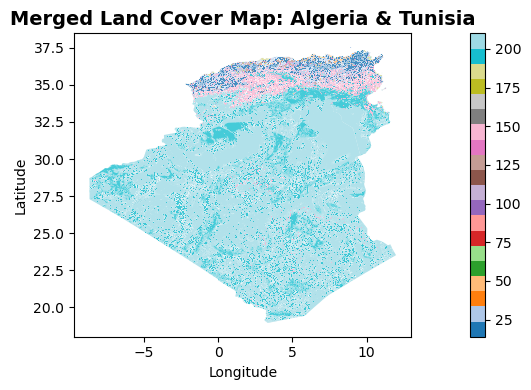

In [19]:
# plot to check merge
fig, ax = plt.subplots(figsize=(12, 4))
landcover_merged.plot(ax=ax, column="GRIDCODE", cmap="tab20", legend=True, linewidth=0, alpha=0.8)

ax.set_title("Merged Land Cover Map: Algeria & Tunisia", fontsize=14, weight="bold")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect("equal")
plt.tight_layout()
plt.savefig(os.path.join(Images_dir, "merged_land_cover_algeria_tunisia.png"))
plt.show()

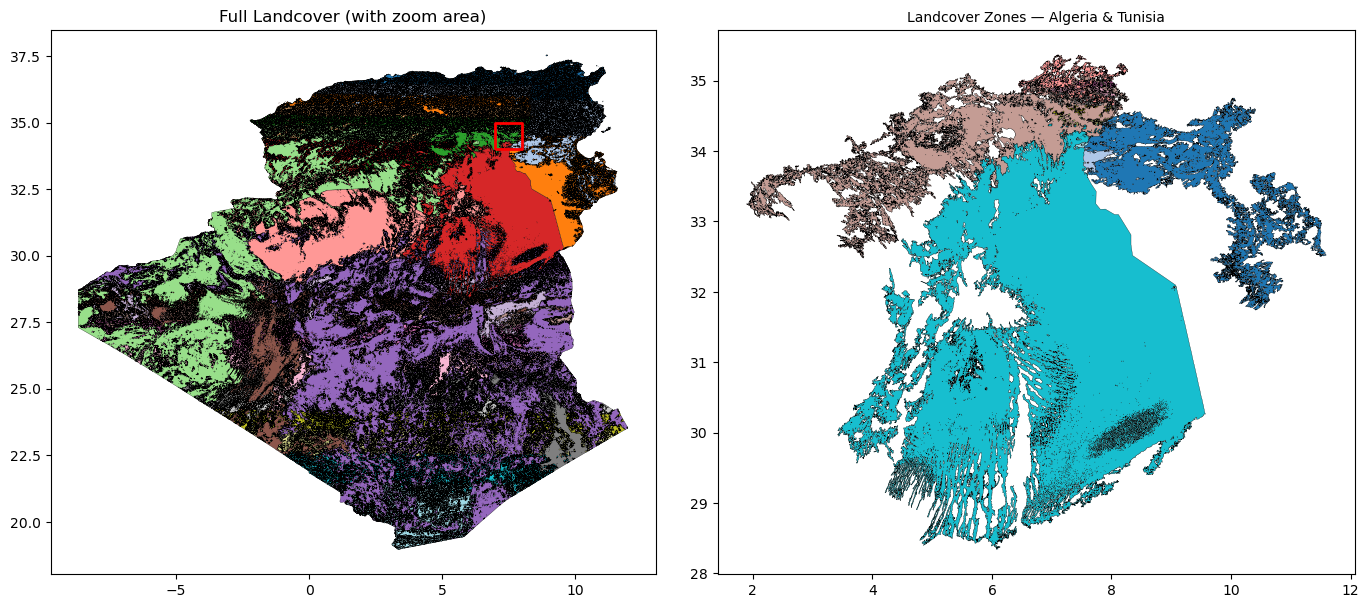

In [74]:
zoom_bounds = [7, 34, 8, 35]  # [minx, miny, maxx, maxy]
zoom_box = box(*zoom_bounds)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: full map with zoom box 
landcover_merged.plot(
    column="ID",
    cmap="tab20",
    edgecolor="black",
    linewidth=0.2,
    ax=axes[0]
)
# draw the red rectangle
gpd.GeoSeries([zoom_box]).boundary.plot(ax=axes[0], color="red", linewidth=2)
axes[0].set_title("Full Landcover (with zoom area)")

# Plot 2: zoomed-in map
subset = landcover_merged.cx[zoom_bounds[0]:zoom_bounds[2], zoom_bounds[1]:zoom_bounds[3]]
subset.plot(
    column="ID",
    cmap="tab20",
    edgecolor="black",
    linewidth=0.2,
    ax=axes[1]
)
axes[1].set_title("Zoomed-in Area")
plt.title("Landcover Zones — Algeria & Tunisia", fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(Images_dir, "landcover_zoomed_area_algeria_tunisia.png"), dpi=300)
plt.show()


### Soil

In [20]:
# keep only required cols and id
soil_features = [
    "HWSD2_SMU_ID", "LAYER", "COARSE", "SAND", "SILT", "CLAY",
    "TEXTURE_USDA", "TEXTURE_SOTER", "BULK", "REF_BULK",
    "ORG_CARBON", "PH_WATER", "TOTAL_N", "CN_RATIO",
    "CEC_SOIL", "CEC_CLAY", "CEC_EFF", "TEB", "BSAT",
    "ALUM_SAT", "ESP", "TCARBON_EQ", "GYPSUM", "ELEC_COND"
]

soil_mdb_df = soil_mdb_df[soil_features]
print("soil columns after filtering:", soil_mdb_df.columns.tolist())

soil columns after filtering: ['HWSD2_SMU_ID', 'LAYER', 'COARSE', 'SAND', 'SILT', 'CLAY', 'TEXTURE_USDA', 'TEXTURE_SOTER', 'BULK', 'REF_BULK', 'ORG_CARBON', 'PH_WATER', 'TOTAL_N', 'CN_RATIO', 'CEC_SOIL', 'CEC_CLAY', 'CEC_EFF', 'TEB', 'BSAT', 'ALUM_SAT', 'ESP', 'TCARBON_EQ', 'GYPSUM', 'ELEC_COND']


In [23]:
from rasterio.mask import mask

# Use already merged landcover polygons
mask_gdf = landcover_merged

# Open raster
with rasterio.open(soil_raster_bil_path) as src:
    raster_crs = src.crs or "EPSG:4326"
    if mask_gdf.crs != raster_crs:
        mask_gdf = mask_gdf.to_crs(raster_crs)
    geoms = [geom.__geo_interface__ for geom in mask_gdf.geometry]
    out_image, out_transform = mask(src, geoms, crop=True, all_touched=False)
    out_meta = src.meta.copy()

out_meta.update({
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})


# Flatten raster and get pixel coordinates
rows, cols = out_image.shape[1], out_image.shape[2]
row_idx, col_idx = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
xs, ys = rasterio.transform.xy(out_transform, row_idx, col_idx)
xs, ys = np.array(xs).flatten(), np.array(ys).flatten()
soil_ids = out_image[0].flatten()

# 2Filter invalid pixels
mask = ~np.isnan(soil_ids)
soil_ids = soil_ids[mask].astype(int)
xs, ys = xs[mask], ys[mask]

print(f"Unique soil IDs found in raster: {len(np.unique(soil_ids))}")

# Create DataFrame with lat/lon
soil_raster_df = pd.DataFrame({
    "longitude": xs,
    "latitude": ys,
    "HWSD2_SMU_ID": soil_ids
})

# Merge with soil attributes
soil_joined = soil_raster_df.merge(soil_mdb_df, on="HWSD2_SMU_ID", how="left")

print("✅ Joined data shape:", soil_joined.shape)
print("Sample of joined data:")
print(soil_joined.head())


Unique soil IDs found in raster: 387
✅ Joined data shape: (9352670, 26)
Sample of joined data:
   longitude   latitude  HWSD2_SMU_ID LAYER  COARSE  SAND  SILT  CLAY  \
0  -8.670833  37.545833         65535   NaN     NaN   NaN   NaN   NaN   
1  -8.662500  37.545833         65535   NaN     NaN   NaN   NaN   NaN   
2  -8.654167  37.545833         65535   NaN     NaN   NaN   NaN   NaN   
3  -8.645833  37.545833         65535   NaN     NaN   NaN   NaN   NaN   
4  -8.637500  37.545833         65535   NaN     NaN   NaN   NaN   NaN   

   TEXTURE_USDA TEXTURE_SOTER  ...  CEC_SOIL  CEC_CLAY  CEC_EFF  TEB  BSAT  \
0           NaN           NaN  ...       NaN       NaN      NaN  NaN   NaN   
1           NaN           NaN  ...       NaN       NaN      NaN  NaN   NaN   
2           NaN           NaN  ...       NaN       NaN      NaN  NaN   NaN   
3           NaN           NaN  ...       NaN       NaN      NaN  NaN   NaN   
4           NaN           NaN  ...       NaN       NaN      NaN  NaN   NaN  

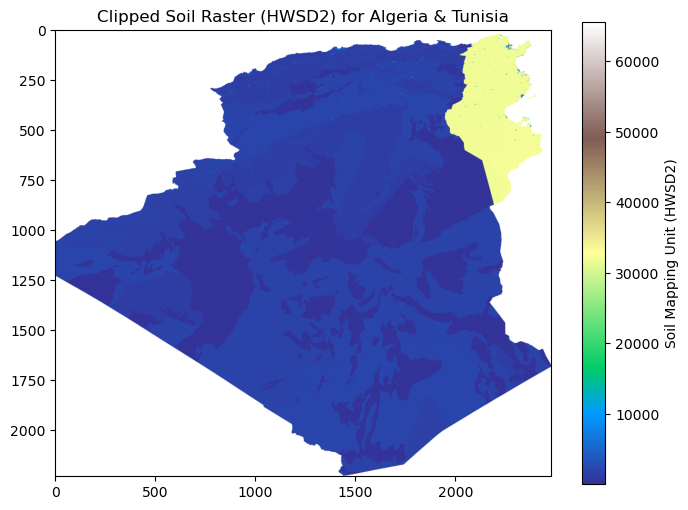

In [24]:
plt.figure(figsize=(8,6))
plt.imshow(out_image[0], cmap="terrain")
plt.colorbar(label="Soil Mapping Unit (HWSD2)")
plt.title("Clipped Soil Raster (HWSD2) for Algeria & Tunisia")
plt.savefig(os.path.join(Images_dir, "clipped_soil_raster_algeria_tunisia.png"))
plt.show()

In [27]:
# Clean index
soil_joined = soil_joined.reset_index(drop=True)

# Save to CSV
soil_csv_path = os.path.join(loaded_data_dir, "soil.csv")
soil_joined.to_csv(soil_csv_path, index=False)

print(f"✅ Saved joined soil data to CSV: {soil_csv_path}")
print("📄 Shape:", soil_joined.shape)

✅ Saved joined soil data to CSV: ../data\loaded\soil.csv
📄 Shape: (9352670, 26)


### climate

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.windows import from_bounds
from rasterio.features import rasterize
from multiprocessing import Pool, cpu_count
from functools import partial

climate_dirs = {
    "prec": os.path.join(climate_dir, "prec"),
    "tmax": os.path.join(climate_dir, "tmax"),
    "tmin": os.path.join(climate_dir, "tmin")
}

clipped_dir = os.path.join(climate_dir, "clipped_2024")
os.makedirs(clipped_dir, exist_ok=True)

# Prepare mask once
mask_gdf = landcover_merged
if mask_gdf.crs is None:
    mask_gdf.set_crs("EPSG:4326", inplace=True)


def process_single_file(args):
    """Process one file - returns only string metadata, no arrays"""
    var, raster_path, mask_gdf, clipped_dir = args
    
    try:
        tif = os.path.basename(raster_path)
        
        with rasterio.open(raster_path) as src:
            raster_crs = src.crs or "EPSG:4326"
            
            # Reproject mask if needed
            if raster_crs != mask_gdf.crs:
                mask_proj = mask_gdf.to_crs(raster_crs)
            else:
                mask_proj = mask_gdf
            
            minx, miny, maxx, maxy = mask_proj.total_bounds
            
            # Read windowed data
            window = from_bounds(minx, miny, maxx, maxy, transform=src.transform)
            window = window.intersection(src.window(*src.bounds))
            transform_window = src.window_transform(window)
            
            nodata_val = src.nodata if src.nodata is not None else -9999
            data_window = src.read(1, window=window, boundless=True, fill_value=nodata_val)
            
            # Rasterize mask
            mask_raster = rasterize(
                [(geom, 1) for geom in mask_proj.geometry],
                out_shape=data_window.shape,
                transform=transform_window,
                fill=0,
                all_touched=False,
                dtype=np.uint8
            )
            
            # Apply mask in-place
            np.putmask(data_window, mask_raster == 0, nodata_val)
            
            # Prepare metadata
            out_meta = src.meta.copy()
            out_meta.update({
                "height": data_window.shape[0],
                "width": data_window.shape[1],
                "transform": transform_window,
                "compress": "lzw",
                "tiled": True,
                "blockxsize": 256,
                "blockysize": 256,
                "nodata": nodata_val
            })
            
            # Save
            out_name = f"clipped_{var}_{tif.split('_')[-1]}"
            out_path = os.path.join(clipped_dir, out_name)
            
            with rasterio.open(out_path, "w", **out_meta) as dst:
                dst.write(data_window, 1)
            
            # Return only strings - no numpy arrays!
            return (var, out_name, out_path, None)
            
    except Exception as e:
        return (var, tif, None, str(e))


# Collect all tasks
tasks = []
for var, folder in climate_dirs.items():
    tif_files = sorted([f for f in os.listdir(folder) if f.endswith(".tif") and "2024" in f])
    for tif in tif_files:
        raster_path = os.path.join(folder, tif)
        tasks.append((var, raster_path, mask_gdf, clipped_dir))

print(f"Processing {len(tasks)} files using {cpu_count()} cores...\n")

# Process in parallel
climate_data_2024 = {var: [] for var in climate_dirs.keys()}

# Use 75% of available cores for optimal performance
n_workers = max(1, int(cpu_count() * 0.75))

with Pool(processes=n_workers) as pool:
    results = pool.map(process_single_file, tasks)

# Collect results
for var, name, path, error in results:
    if error:
        print(f"❌ Error processing {name}: {error}")
    else:
        climate_data_2024[var].append({"name": name, "path": path})
        print(f"✅ {name}")

print(f"\n-> Processed {sum(len(v) for v in climate_data_2024.values())} files successfully!")

In [8]:
import os
import numpy as np
import pandas as pd
import rasterio
import xarray as xr

# ---------------------------
# Paths and variables
# ---------------------------
clipped_dir = r"C:\Users\T14s\Desktop\M2\Data mining\data\clipped_fnl"
output_csv = os.path.join(loaded_data_dir, "climate.csv")
variables = ["prec", "tmin", "tmax"]

# Get files for each variable
var_files = {
    var: sorted([
        os.path.join(clipped_dir, f)
        for f in os.listdir(clipped_dir)
        if f.endswith(".tif") and f"_{var}_" in f
    ])
    for var in variables
}

# ---------------------------
# Get coordinates from first raster
# ---------------------------
with rasterio.open(var_files["prec"][0]) as src:
    shape = src.read(1).shape
    rows, cols = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing="ij")
    lons_1d, lats_1d = rasterio.transform.xy(src.transform, rows, cols)
    lons = np.array(lons_1d).reshape(shape)
    lats = np.array(lats_1d).reshape(shape)
    lon_vals = lons[0, :]
    lat_vals = lats[:, 0]

# ---------------------------
# Read rasters + diagnostic check
# ---------------------------
data_vars = {}
missing_summary = {}  # store stats for each var

for var, files in var_files.items():
    arr_list = []
    total_missing = 0
    total_pixels = 0

    print(f"\n📊 Checking missing values for '{var}'")
    for f in files:
        with rasterio.open(f) as src:
            data = src.read(1)
            nodata = src.nodata
            if nodata is None or np.isnan(nodata):
                mask = np.isfinite(data)
            else:
                mask = data != nodata

            # Count missing
            missing_pixels = np.count_nonzero(~mask)
            total_pixels += data.size
            total_missing += missing_pixels

            print(f"  {os.path.basename(f)} → missing: {missing_pixels:,} / {data.size:,}")

            arr_list.append(np.where(mask, data, np.nan))

    missing_summary[var] = {
        "total_missing": total_missing,
        "total_pixels": total_pixels,
        "missing_percent": 100 * total_missing / total_pixels
    }

    arr = np.stack(arr_list, axis=0)
    data_vars[var] = (("time", "lat", "lon"), arr)

# ---------------------------
# Show summary table
# ---------------------------
print("\n=== Missing Data Summary ===")
for var, stats in missing_summary.items():
    print(f"{var}: {stats['missing_percent']:.2f}% missing ({stats['total_missing']:,} / {stats['total_pixels']:,})")

# ---------------------------
# Build dataset and save CSV
# ---------------------------
ds = xr.Dataset(
    data_vars,
    coords={"time": np.arange(1, 13), "lat": lat_vals, "lon": lon_vals}
)

df = ds.to_dataframe().reset_index()
df = df.dropna(subset=variables, how="all")  # drop ocean/border
df.to_csv(output_csv, index=False)

print(f"\n✅ Saved CSV: {output_csv}")
print("Shape:", df.shape)



📊 Checking missing values for 'prec'
  clipped_wc2.1_cruts4.09_5m_prec_2024-01.tif → missing: 22,849 / 55,776
  clipped_wc2.1_cruts4.09_5m_prec_2024-02.tif → missing: 22,849 / 55,776
  clipped_wc2.1_cruts4.09_5m_prec_2024-03.tif → missing: 22,849 / 55,776
  clipped_wc2.1_cruts4.09_5m_prec_2024-04.tif → missing: 22,849 / 55,776
  clipped_wc2.1_cruts4.09_5m_prec_2024-05.tif → missing: 22,849 / 55,776
  clipped_wc2.1_cruts4.09_5m_prec_2024-06.tif → missing: 22,849 / 55,776
  clipped_wc2.1_cruts4.09_5m_prec_2024-07.tif → missing: 22,849 / 55,776
  clipped_wc2.1_cruts4.09_5m_prec_2024-08.tif → missing: 22,849 / 55,776
  clipped_wc2.1_cruts4.09_5m_prec_2024-09.tif → missing: 22,849 / 55,776
  clipped_wc2.1_cruts4.09_5m_prec_2024-10.tif → missing: 22,849 / 55,776
  clipped_wc2.1_cruts4.09_5m_prec_2024-11.tif → missing: 22,849 / 55,776
  clipped_wc2.1_cruts4.09_5m_prec_2024-12.tif → missing: 22,849 / 55,776

📊 Checking missing values for 'tmin'
  clipped_wc2.1_cruts4.09_5m_tmin_2024-01.tif → 

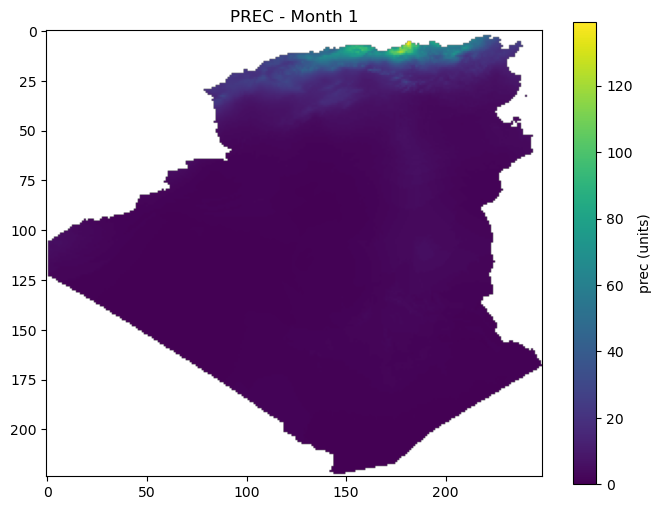

In [50]:
# plot climate data sample
sample_var = "prec"
sample_time = 0  # January
plt.figure(figsize=(8, 6))
plt.imshow(ds[sample_var][sample_time, :, :], cmap="viridis")
plt.colorbar(label=f"{sample_var} (units)")
plt.title(f"{sample_var.upper()} - Month {sample_time + 1}")
plt.savefig(os.path.join(Images_dir, f"{sample_var}_month_{sample_time + 1}_climate_sample.png"))
plt.show()

### elevation

In [48]:
from rasterio.mask import mask


# make sure it's only Algeria & Tunisia polygons
mask_gdf = landcover_merged.copy()
mask_gdf = mask_gdf.buffer(0)  # fix invalid geometries if any

with rasterio.open(elevation_path) as src:
    raster_crs = src.crs or "EPSG:4326"

    # align CRS
    if mask_gdf.crs != raster_crs:
        mask_gdf = mask_gdf.to_crs(raster_crs)

    # clip strictly within polygons (ignore small overlap at edges)
    geoms = [geom.__geo_interface__ for geom in mask_gdf.geometry]
    out_image, out_transform = mask(
        src, geoms, crop=True, all_touched=False
    )
    out_meta = src.meta.copy()
    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })


In [ ]:
# flatten raster to coordinates and values
rows, cols = np.meshgrid(
    np.arange(out_image.shape[1]),
    np.arange(out_image.shape[2]),
    indexing="ij"
)
xs, ys = rasterio.transform.xy(out_transform, rows, cols)
xs, ys = np.array(xs).flatten(), np.array(ys).flatten()
elev_vals = out_image[0].flatten()

# remove invalid pixels
mask_valid = ~np.isnan(elev_vals)
xs, ys, elev_vals = xs[mask_valid], ys[mask_valid], elev_vals[mask_valid]

# make DataFrame
elev_df = pd.DataFrame({
    "longitude": xs,
    "latitude": ys,
    "elevation": elev_vals
})


✅ Saved elevation data to: ../data\loaded\elevation.csv
Shape: (22117638, 3)
   longitude   latitude  elevation
0  -8.673056  37.543611     -32768
1  -8.668889  37.543611     -32768
2  -8.664722  37.543611     -32768
3  -8.660556  37.543611     -32768
4  -8.656389  37.543611     -32768


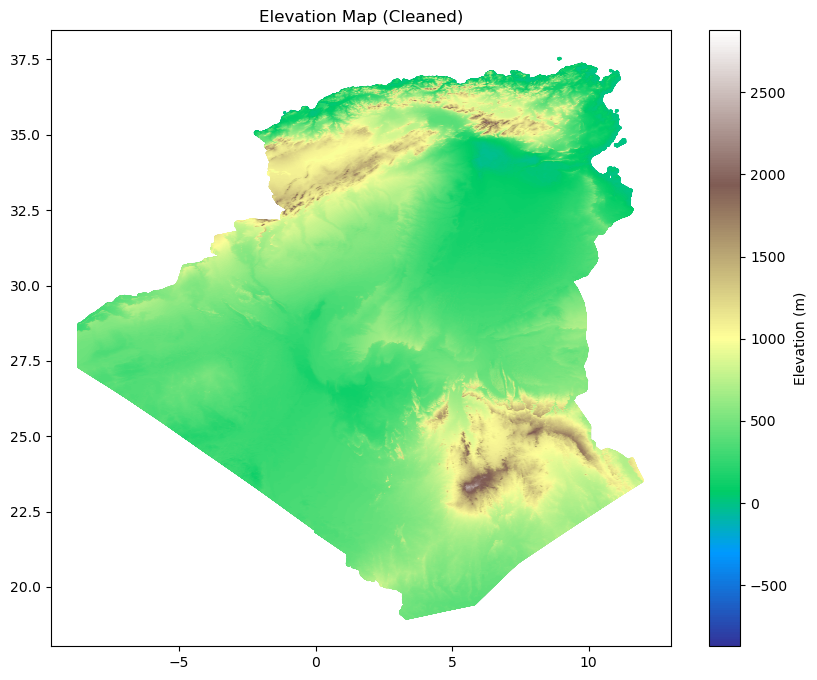

In [57]:
# remove where elevation = -32768 and plot map
elev_df = elev_df[elev_df["elevation"] != -32768]
plt.figure(figsize=(10, 8))
plt.scatter(elev_df["longitude"], elev_df["latitude"], c=elev_df["elevation"], cmap="terrain", s=1)
plt.colorbar(label="Elevation (m)")
plt.title("Elevation Map (Cleaned)")
plt.savefig(os.path.join(Images_dir, "elevation_cleaned_map.png"))
plt.show()

In [58]:
# save to CSV
output_csv = os.path.join(loaded_data_dir, "elevation.csv")
elev_df.to_csv(output_csv, index=False)

print(f"Saved elevation data to: {output_csv}")
print("Shape:", elev_df.shape)
print(elev_df.head())

Saved elevation data to: ../data\loaded\elevation.csv
Shape: (13167778, 3)
       longitude   latitude  elevation
9185    8.939444  37.539444          0
9186    8.943611  37.539444          1
9187    8.947778  37.539444          0
14142   8.935278  37.535278          0
14143   8.939444  37.535278          0


### save landcover

In [62]:
print(landcover_merged.head())

   ID  GRIDCODE       AREA_M2       LCCCode  \
0   4       210  6.228187e+06  7001 // 8001   
1   2       210  6.242408e+06  7001 // 8001   
2   1       210  1.482995e+06  7001 // 8001   
3   8        50  4.590841e+08  21497-121340   
4  13       210  6.371533e+06  7001 // 8001   

                                            geometry  
0  POLYGON ((6.41528 37.08696, 6.43103 37.0855, 6...  
1  POLYGON ((7.18084 37.07917, 7.17998 37.08091, ...  
2  POLYGON ((7.37137 37.08194, 7.3709 37.08717, 7...  
3  POLYGON ((6.12361 36.68472, 6.12361 36.69306, ...  
4  POLYGON ((6.26181 37.02361, 6.26193 37.02514, ...  


In [63]:
# save landcover merged to CSV
landcover_csv_path = os.path.join(loaded_data_dir, "landcover.csv")
landcover_merged.to_csv(landcover_csv_path, index=False)
print(f"Saved merged landcover data to CSV: {landcover_csv_path}")

Saved merged landcover data to CSV: ../data\loaded\landcover.csv


### concat and save fire

In [59]:
# concat the 2 fire datasets, add column country
algeria_fire["country"] = "Algeria"
tunisia_fire["country"] = "Tunisia"
fire_data = pd.concat([algeria_fire, tunisia_fire], ignore_index=True)
print("Concatenated fire data shape:", fire_data.shape)
print(fire_data.head())

Concatenated fire data shape: (90250, 16)
   latitude  longitude  bright_ti4  scan  track    acq_date  acq_time  \
0  27.72818    9.87200      295.51  0.76   0.77  2024-01-01         3   
1  28.63288    9.77909      301.80  0.79   0.78  2024-01-01         3   
2  28.64012    9.77953      298.65  0.79   0.78  2024-01-01         3   
3  36.74886    6.25409      338.04  0.46   0.39  2024-01-01       141   
4  35.87978    4.44782      309.49  0.41   0.37  2024-01-01       141   

  satellite instrument confidence  version  bright_ti5   frp daynight  type  \
0       N20      VIIRS          n        2      277.66  1.24        N     2   
1       N20      VIIRS          n        2      277.05  1.57        N     2   
2       N20      VIIRS          n        2      277.04  1.34        N     2   
3       N20      VIIRS          n        2      257.28  5.21        N     2   
4       N20      VIIRS          n        2      272.08  1.58        N     2   

   country  
0  Algeria  
1  Algeria  
2  Al

In [60]:
# save to CSV
fire_csv_path = os.path.join(loaded_data_dir, "fire.csv")
fire_data.to_csv(fire_csv_path, index=False)
print(f"Saved fire data to CSV: {fire_csv_path}")

Saved fire data to CSV: ../data\loaded\fire.csv
